## Goal : Create short-term temperature forecast.

- Understand the purpose of Time Series Analysis
- Understand the concept of time dependence in time series data
- Understand how to use AR and ARIMA models in order to predict the future

Data and metadata available at http://www.ecad.eu

* FILE FORMAT (MISSING VALUE CODE IS -9999):
* 01-06 SOUID: Source identifier
* 08-15 DATE : Date YYYYMMDD
* 17-21 TG   : mean temperature in 0.1 &#176;C
* 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BREMEN (STAID: 42)

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.express as px
init_notebook_mode(connected=True)
import ipywidgets as widgets

# hide warnings
import warnings
warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.figure(figsize=[20,10])

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

### Load & Explore Data

In [2]:
# read the csv file into a DataFrame 
data = pd.read_csv('../data/TG_STAID000042.txt', sep=',', comment='%', skiprows=18, skipfooter=10)

##format and rename columns
data.columns = data.columns.str.strip() 
cols = ['source_id', 'date', 'temp', 'q_temp']
data.columns = cols

#Convert date to DateTime format and set as index
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data.set_index('date', inplace=True)

#convert mean temperature in 0.1 °C
data['temp'] = data['temp'] * 0.1

#drop missing / suspect values
data.drop(data.loc[data['q_temp']>=1].index, inplace=True)

# Consider data from 1950 due to lots of missing data from 1876-1946
df = data[ data.year >= 1950 ]

In [3]:
df

source_id  temp  q_temp  year  month  day
date                                                 
1950-01-01     100138  -1.0       0  1950      1    1
1950-01-02     100138   3.7       0  1950      1    2
1950-01-03     100138   4.5       0  1950      1    3
1950-01-04     100138   0.5       0  1950      1    4
1950-01-05     100138   2.4       0  1950      1    5
...               ...   ...     ...   ...    ...  ...
2020-10-17     100138   8.4       0  2020     10   17
2020-10-18     100138   8.0       0  2020     10   18
2020-10-19     100138   8.8       0  2020     10   19
2020-10-20     100138   9.3       0  2020     10   20
2020-10-21     100138  14.3       0  2020     10   21

[25862 rows x 6 columns]

In [4]:
df.describe(include='all')

source_id          temp   q_temp          year         month  \
count    25862.0  25862.000000  25862.0  25862.000000  25862.000000   
mean    100138.0      9.391068      0.0   1984.904609      6.509783   
std          0.0      6.924341      0.0     20.440283      3.444226   
min     100138.0    -15.600000      0.0   1950.000000      1.000000   
25%     100138.0      4.400000      0.0   1967.000000      4.000000   
50%     100138.0      9.600000      0.0   1985.000000      7.000000   
75%     100138.0     14.700000      0.0   2003.000000      9.000000   
max     100138.0     30.000000      0.0   2020.000000     12.000000   

                day  
count  25862.000000  
mean      15.725543  
std        8.799271  
min        1.000000  
25%        8.000000  
50%       16.000000  
75%       23.000000  
max       31.000000

In [5]:
#Visualize Temperature Time Series
fig = px.line(x=df.index, y=df.temp)
fig.update_layout(title_text="Temperature Time Series", xaxis_title="Date", yaxis_title="Temperature, C")
fig.update_xaxes(rangeslider_visible=True, 
rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")])))
fig.show()

### Check for Stationarity (Augmented Dickey-Fuller Test)

In [6]:
from statsmodels.tsa.stattools import adfuller

print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
result = adfuller(df.temp.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

p = result[1]
if (p > 0.05):
    print("Time Series is NOT Stationary, since p-value > 0.05")
    df = df.diff()  # differencing to make data stationary
else:
    print("Time Series is Stationary, since p-value <= 0.05")

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -12.286421
p-value: 0.000000
Time Series is Stationary, since p-value <= 0.05


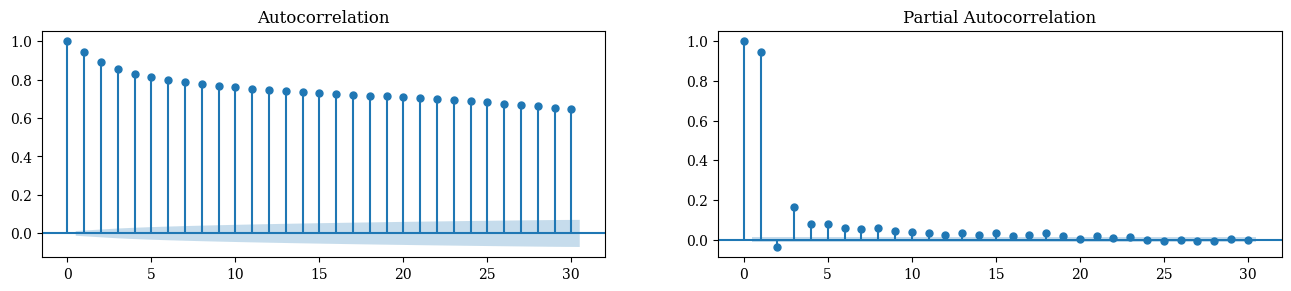

In [7]:
# Autocorrelation and partial autocorrelation functions
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.temp.tolist(), lags=30, ax=axes[0])
plot_pacf(df.temp.tolist(), lags=30, ax=axes[1])
plt.show()

### ARIMA MODEL 1

In [8]:
# Create Training and Test
X = df.temp
train_size = int(len(X) * 0.99) #first 99% for training & remaining 25% for testing
train, test = X[:train_size], X[train_size:]
date = df.index[:train_size]

In [9]:
# with statsmodel, aic check of params (p,q)
from statsmodels.tsa import stattools as st

st.arma_order_select_ic(train, ic='aic')

{'aic':                0              1              2
 0  171764.595727  146276.298247  133634.686898
 1  114563.999946  114516.456696  113715.688062
 2  114533.146456  113609.560308  112980.514107
 3  113830.468541  113034.089615  112979.350600
 4  113659.747660  112980.185619  112980.205737,
 'aic_min_order': (3, 2)}

In [10]:
# predict with statsmodel, p,q & d values already obtained in Timeseries_Forecast_Bremen notebook

from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(train, order=[3,0,2],).fit(ic='aic', dates=date)

arima_predict = arima.predict('2020-02-06','2020-10-21')

C:\Users\pbamo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [11]:
# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(name="Raw Data", x=df.index, y=df.temp))
fig.add_trace(go.Scatter(name="ARIMA model Prediction", x=arima_predict.index, y=arima_predict))
fig.update_layout(title_text="ARIMA MODEL", xaxis_title="Date", yaxis_title="Temperature, C")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [12]:
# compare actual test values with predicted values, as well as the residuals & proportional error 
eval_df = pd.DataFrame({"actual_temp": test, "predicted_temp": arima_predict})
eval_df["residuals"] = test - arima_predict
eval_df["prop_error"] = eval_df["residuals"].abs()/eval_df["actual_temp"]
eval_df 

actual_temp  predicted_temp  residuals  prop_error
2020-02-06          4.9        3.989786   0.910214    0.185758
2020-02-07          5.2        4.644007   0.555993    0.106922
2020-02-08          4.8        5.034904  -0.234904    0.048938
2020-02-09          9.8        5.288997   4.511003    0.460306
2020-02-10          6.3        5.456880   0.843120    0.133829
...                 ...             ...        ...         ...
2020-10-17          8.4        8.884199  -0.484199    0.057643
2020-10-18          8.0        8.887810  -0.887810    0.110976
2020-10-19          8.8        8.891389  -0.091389    0.010385
2020-10-20          9.3        8.894938   0.405062    0.043555
2020-10-21         14.3        8.898456   5.401544    0.377730

[259 rows x 4 columns]

In [13]:
# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(name="Raw Data", x=df.index, y=df.temp))
fig.add_trace(go.Scatter(name="ARIMA model Prediction", x=arima_predict.index, y=arima_predict))
fig.update_layout(xaxis_range=['2017-01-01','2020-12-31'], title_text="ARIMA MODEL")
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title_text="ARIMA MODEL", xaxis_title="Date", yaxis_title="Temperature, C")
fig.show()

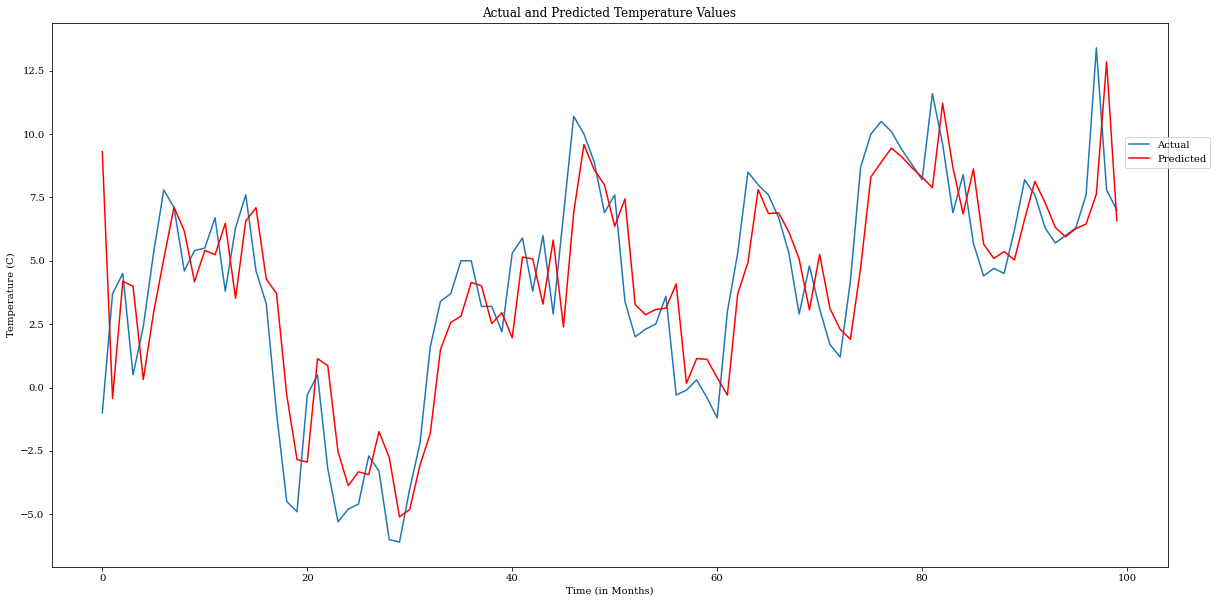

In [14]:
# comparing first 100 predictions with actual values

arima_pred = arima.predict(start=0, end=len(train)-1)
plt.plot(list(train)[:100], label="Actual")
plt.plot(list(arima_pred)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.00, 0.8))
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(list(train), list(arima_pred))
mae = mean_absolute_error(list(train), list(arima_pred))
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 4.830754332960861
Mean Absolute Error: 1.719255010533227


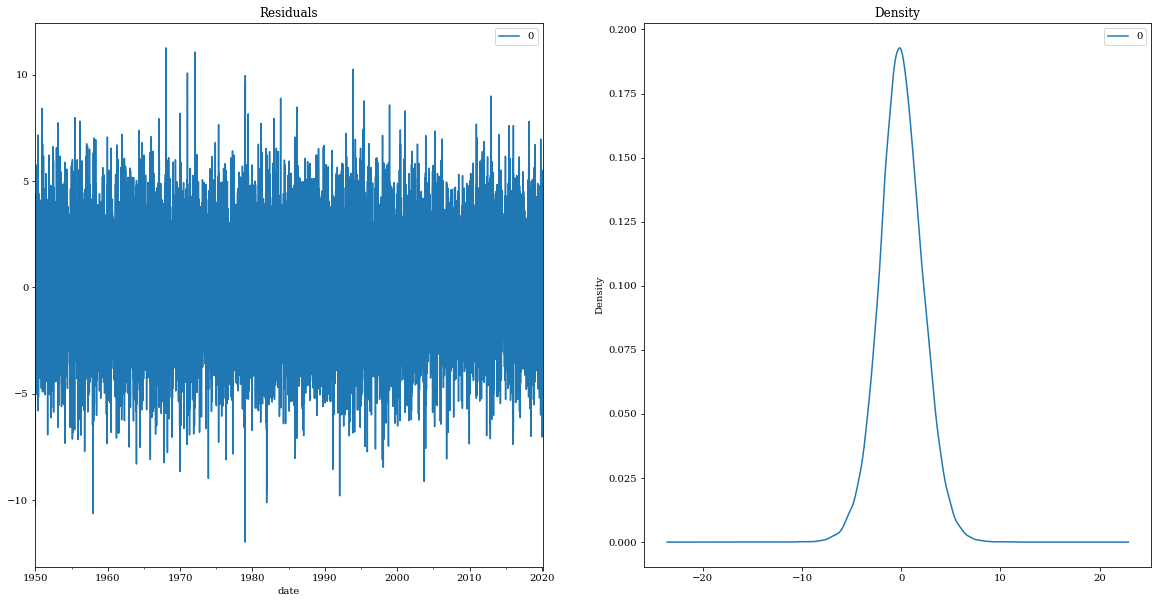

In [16]:
# Plot residual errors
residuals = pd.DataFrame(arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## Residual errors seem fine with near zero mean and uniform variance.

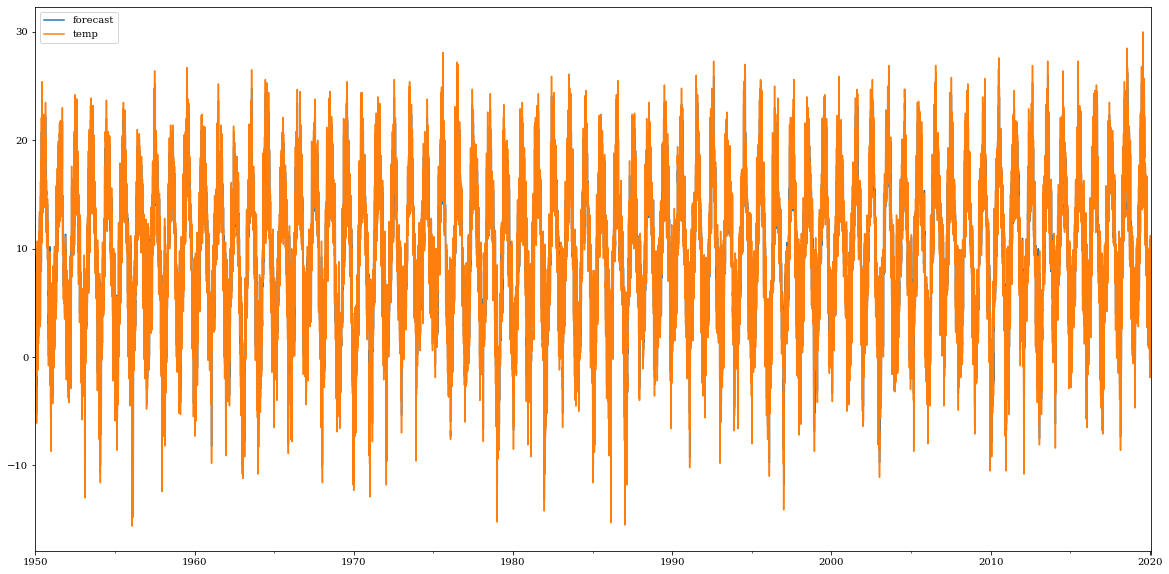

In [17]:
# Actual vs Fitted

arima.plot_predict(dynamic=False)
plt.show()

# dynamic=False, the in-sample lagged values are used for prediction, i.e. the model gets trained up until the previous value to make the next prediction.

### ARIMA MODEL 2

C:\Users\pbamo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



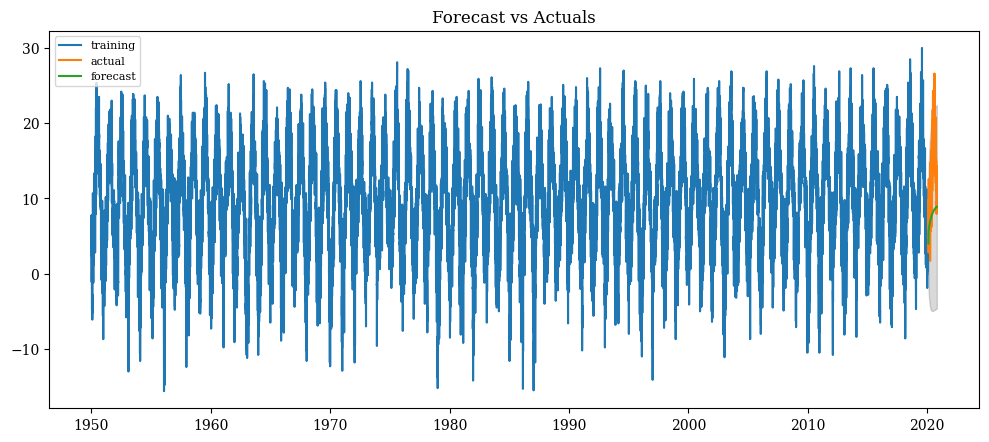

In [18]:
# Build Model 
model_2 = ARIMA(train, order=(3, 0, 2)).fit() 

# Forecast on test data
fc, se, conf = model_2.forecast(259, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
## Accuracy Metrics

def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'me':me, 'mae': mae, 'rmse':rmse,})

forecast_accuracy(fc, test.values)

{'me': -5.285534359297582,
 'mae': 5.812395033188144,
 'rmse': 7.2578484348803345}

### ARIMA Model 3

In [20]:
import pmdarima as pm

model_3 = pm.auto_arima(df.temp, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_3.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=116138.518, Time=2.99 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=200472.259, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=116149.142, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=170696.787, Time=2.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=115966.273, Time=5.67 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=116143.106, Time=0.78 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=114203.897, Time=7.88 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=115283.813, Time=0.98 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=114157.472, Time=4.65 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=114147.116, Time=8.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=115072.979, Time=4.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=114144.667, Time=14.47 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=114561.484, Time=6.30 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=114149.837, Time=14.54 sec
 AR

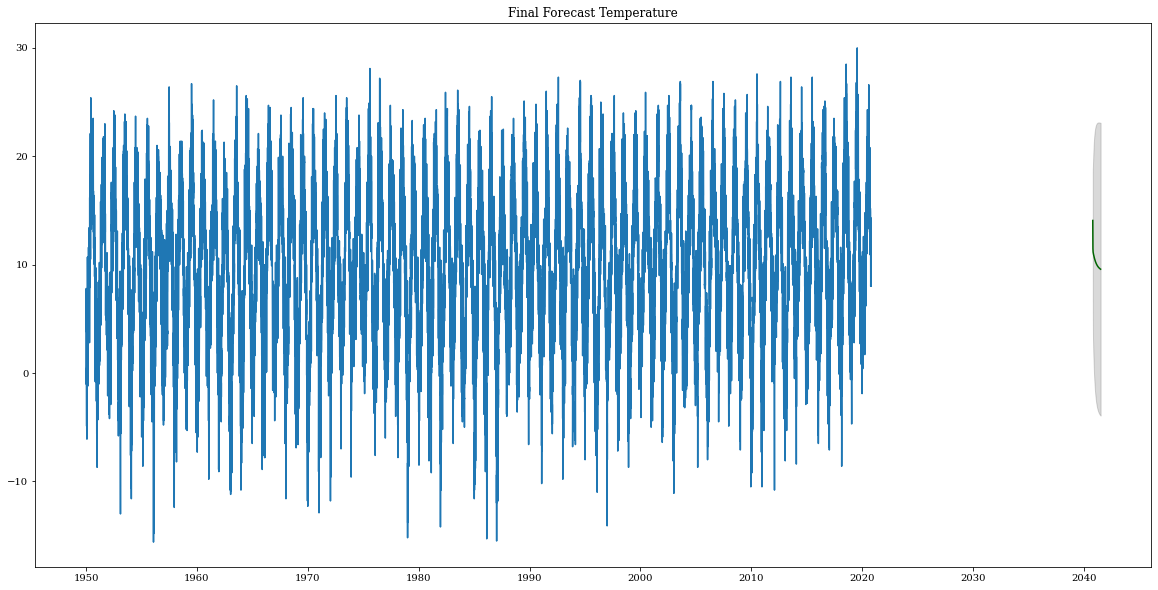

In [21]:
# Forecast
n_periods = 259
fc, confint = model_3.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.temp), len(df.temp)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.temp)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast Temperature")
plt.show()